In [1]:
# get RetinaNet Library
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6205, done.
remote: Total 6205 (delta 0), reused 0 (delta 0), pack-reused 6205
Receiving objects: 100% (6205/6205), 13.47 MiB | 1.18 MiB/s, done.
Resolving deltas: 100% (4199/4199), done.


In [2]:
# install RetinaNet
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=167026 sha256=ce7010138db40f4b41d55a27b445ef467ebde27ce361bfe2ba075be727f83ec2
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=067b80a729be90728a1e61ad7744d2b24754f82d923d4425597e6f6aa5347a47
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import urllib
import os
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

In [5]:
# download pretrained RetinaNet
urllib.request.urlretrieve('https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5',
    'pretrained_model.h5')

('pretrained_model.h5', <http.client.HTTPMessage at 0x7f81fd3fbdd8>)

In [6]:
model = models.load_model('pretrained_model.h5')

In [7]:
!wget https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt

--2021-02-09 14:45:54--  https://lazyprogrammer.me/course_files/obj_detection/coco_categories.txt
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘coco_categories.txt’

coco_categories.txt     [ <=>                ]     621  --.-KB/s    in 0s      

2021-02-09 14:45:55 (14.2 MB/s) - ‘coco_categories.txt’ saved [621]



In [8]:
class_names = [l.rstrip() for l in open('coco_categories.txt')]

In [9]:
class_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [17]:
def show_image_with_prediction(img_path, threshold=0.6):
    im = np.array(Image.open(img_path))
    print("im.shape:", im.shape)

    # if there is ja transparent alpha channel
    im = im[:, :, :3]

    # plot prediction
    imp = preprocess_image(im)
    imp, scale = resize_image(im)

    boxes, scores, labels = model.predict_on_batch(
        np.expand_dims(imp, axis=0))
    
    # standartize box coordinates
    boxes /= scale

    # loop through each prediction for the input image
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < threshold:
            break
        
        box = box.astype(np.int32)
        color = label_color(label)
        draw_box(im, box, color=color)

        class_name = class_names[label]
        caption = f"{class_name} {score:.3f}"
        draw_caption(im, box, caption)

    plt.axis('off')
    plt.imshow(im)
    plt.show()

In [12]:
plt.rcParams['figure.figsize'] = [20, 10]

In [13]:
!wget https://lazyprogrammer.me/course_files/obj_detection/baseball.jpg

--2021-02-09 14:56:17--  https://lazyprogrammer.me/course_files/obj_detection/baseball.jpg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162736 (159K) [image/jpeg]
Saving to: ‘baseball.jpg’

baseball.jpg        100%[===================>] 158.92K   587KB/s    in 0.3s    

2021-02-09 14:56:18 (587 KB/s) - ‘baseball.jpg’ saved [162736/162736]



im.shape: (430, 638, 3)


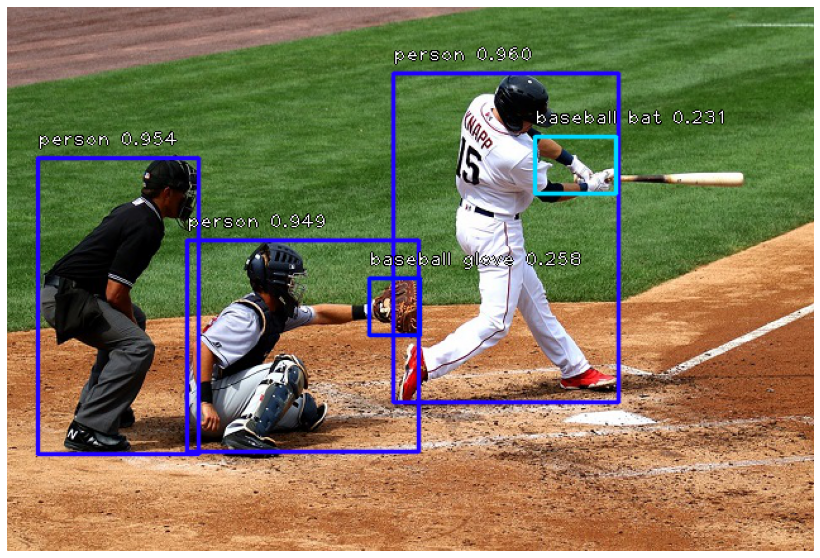

In [21]:
show_image_with_prediction('baseball.jpg', threshold=0.2)

In [19]:
!wget https://lazyprogrammer.me/course_files/obj_detection/cars.jpg

--2021-02-09 14:58:31--  https://lazyprogrammer.me/course_files/obj_detection/cars.jpg
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 220485 (215K) [image/jpeg]
Saving to: ‘cars.jpg’

cars.jpg            100%[===================>] 215.32K   603KB/s    in 0.4s    

2021-02-09 14:58:33 (603 KB/s) - ‘cars.jpg’ saved [220485/220485]



im.shape: (666, 1000, 3)


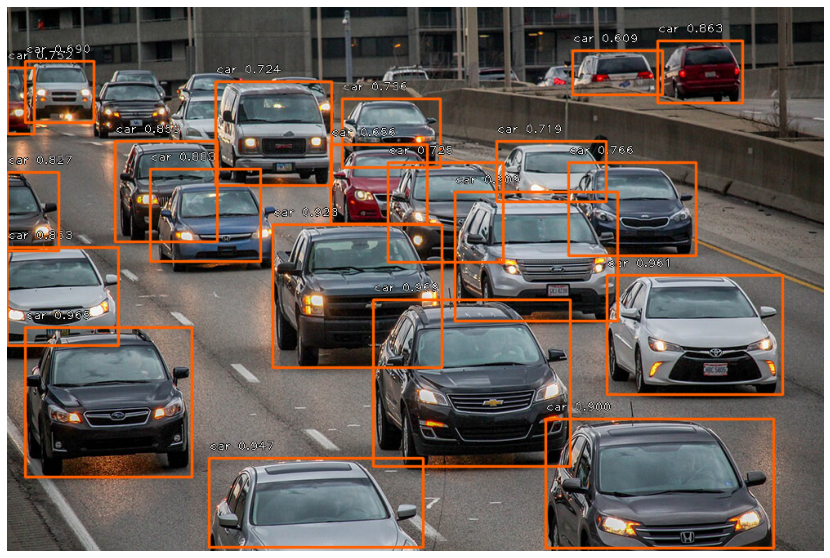

In [20]:
show_image_with_prediction('cars.jpg')